In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import numpy as np

## Dataset: VHM Historical Data

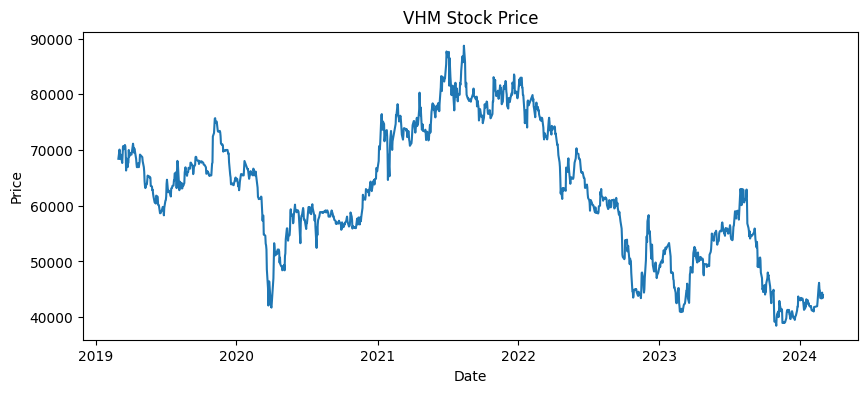

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,68421,"66,541","68,722","65,789",1.05M,4.00%
2019-03-04,70075,"69,173","70,300","67,368",1.18M,2.42%
2019-03-05,68421,"69,323","69,849","68,045",1.50M,-2.36%
2019-03-06,69022,"68,421","69,097","68,270",770.13K,0.88%
2019-03-07,69173,"69,173","71,654","69,097",1.70M,0.22%
...,...,...,...,...,...,...
2024-02-26,43350,"43,450","43,850","43,100",7.00M,-0.23%
2024-02-27,44200,"43,750","44,200","43,300",7.16M,1.96%
2024-02-28,44400,"44,450","44,900","44,000",6.28M,0.45%


In [13]:
data = pd.read_csv('./Datasets/1 - VHM Historical Data.csv', parse_dates = ['Date'], index_col=['Date'])
data = data.sort_index()
plt.figure(figsize=(10, 4))
plt.plot(data['Price'])
plt.title('VHM Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14367.051, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14372.658, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14373.414, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14373.286, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14371.571, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14375.119, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14374.602, Time=0.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14365.850, Time=0.99 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14373.419, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=14367.676, Time=0.91 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=14367.912, Time=1.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14366.044, Time=0.71 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=14369.409, Time=0.43 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(3,1,2)(0,0,0)[0]  

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


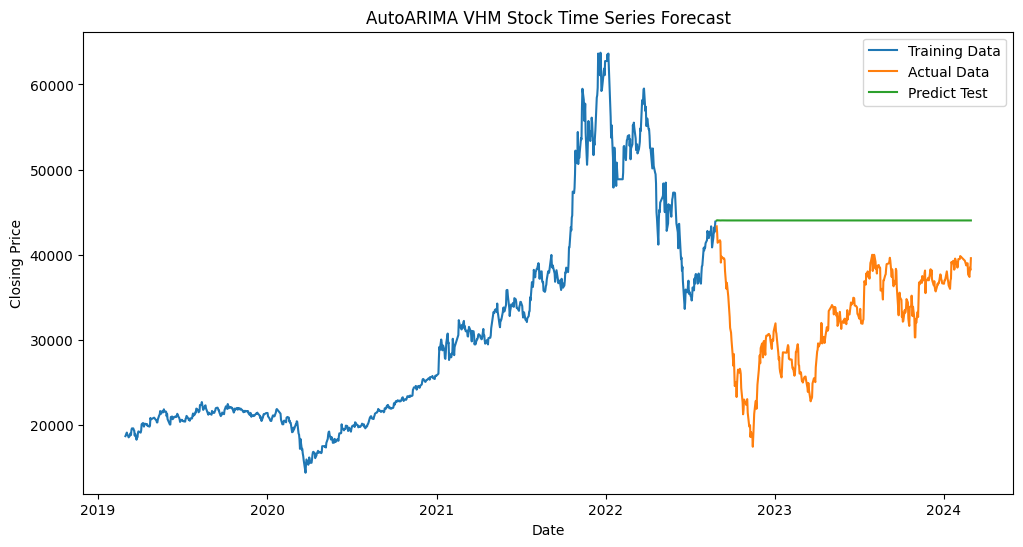

In [12]:
time_series = data['Price']

train_size = int(0.7 * len(time_series))
test_size = int(0.3 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size+test_size]

model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))


plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.title('AutoARIMA VHM Stock Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [5]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 12934.59547106132
Testing MAPE: 25.240563516715774
Testing MAE: 11394.666666666666


## Dataset: NVL Historical Data

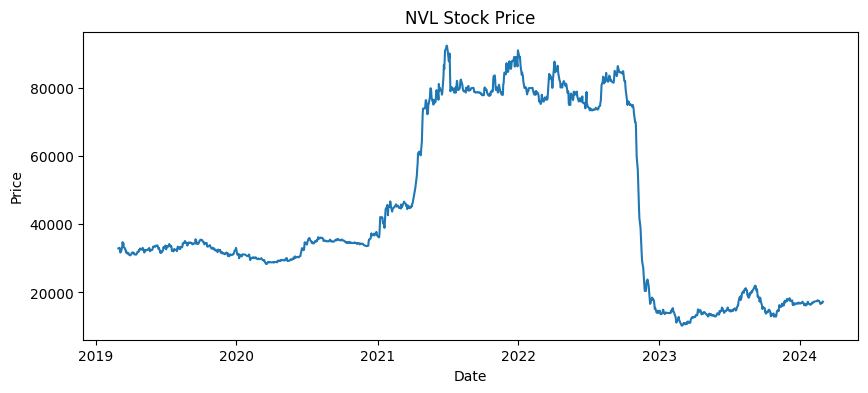

In [6]:
data = pd.read_csv('./Datasets/2 - NVL Historical Data.csv', parse_dates = ['Date'], index_col=['Date'])
data = data.sort_index()
plt.figure(figsize=(10, 4))
plt.plot(data['Price'])
plt.title('NVL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=16668.495, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=17065.087, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=16920.154, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=16723.076, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=16666.109, Time=0.22 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=16665.266, Time=0.25 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=16664.821, Time=0.17 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=16665.579, Time=0.41 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=16665.628, Time=0.25 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=16667.301, Time=0.75 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=16666.561, Time=0.26 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 2.771 seconds


c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


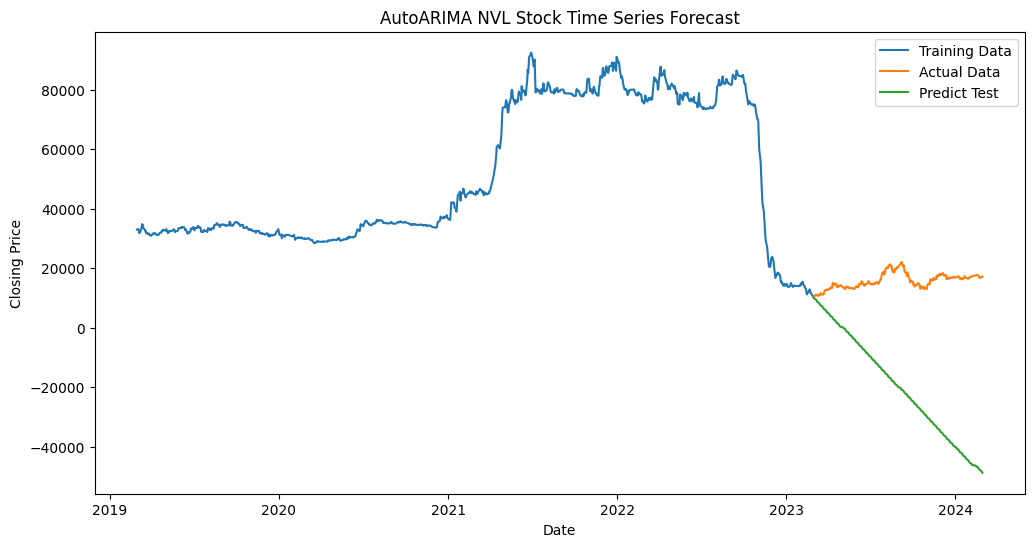

In [7]:
time_series = data['Price']

train_size = int(0.8 * len(time_series))
test_size = int(0.2 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size+test_size]

model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))


plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.title('AutoARIMA NVL Stock Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [8]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 39671.44766141355
Testing MAPE: 215.56246549174082
Testing MAE: 35066.49229800628


## Dataset: NLG Historical Data

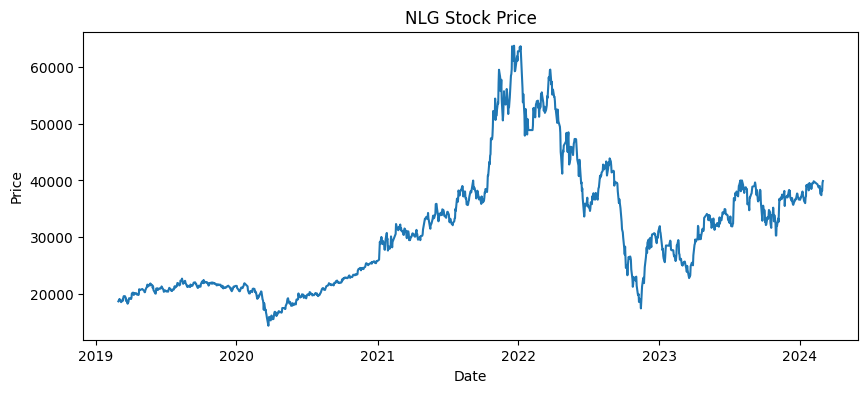

In [9]:
data = pd.read_csv('./Datasets/3 - NLG Historical Data.csv', parse_dates = ['Date'], index_col=['Date'])
data = data.sort_index()
plt.figure(figsize=(10, 4))
plt.plot(data['Price'])
plt.title('NLG Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12153.966, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12165.325, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12166.339, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12166.172, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12166.076, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12165.797, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12164.767, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12155.662, Time=0.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12155.951, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12167.225, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12163.632, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12164.359, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12157.803, Time=0.82 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=12155.053, Time=0.44 sec

Best model:  ARIMA

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


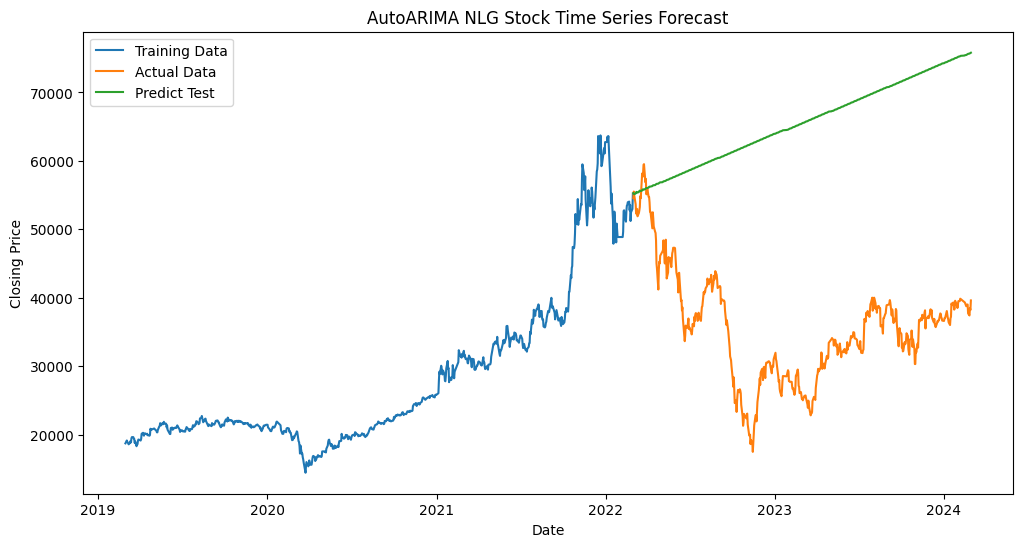

In [10]:
time_series = data['Price']

train_size = int(0.6 * len(time_series))
test_size = int(0.4 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size+test_size]

model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))


plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.title('AutoARIMA NLG Stock Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [11]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 32006.069039338203
Testing MAPE: 94.4768654483854
Testing MAE: 30027.804941329552
